# 라이브러리 import

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import optimizers
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, BatchNormalization, Input
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.layers import Dropout

from keras.preprocessing.image import ImageDataGenerator

# 데이터 불러와서 train test 나누기

In [2]:
BATCH_SIZE = 128

train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=45,
                                   width_shift_range=.15,
                                   height_shift_range=.15,
                                   horizontal_flip=True,
                                   zoom_range=0.5,
                                   validation_split=0.2)  # val 20%

val_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)


train_data = train_datagen.flow_from_directory("./2flowers", 
                                               target_size=(150, 150), 
                                               color_mode='rgb',
                                               batch_size=BATCH_SIZE, 
                                               class_mode='binary',
                                               shuffle=True,
                                               subset = 'training') 

val_data = val_datagen.flow_from_directory("./2flowers", 
                                           target_size=(150, 150), 
                                           color_mode='rgb',
                                           batch_size=BATCH_SIZE, 
                                           class_mode='binary',
                                           shuffle=False,
                                           subset = 'validation')

Found 452 images belonging to 2 classes.
Found 112 images belonging to 2 classes.


In [3]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

In [4]:
sample_training_images, _ = next(train_data)

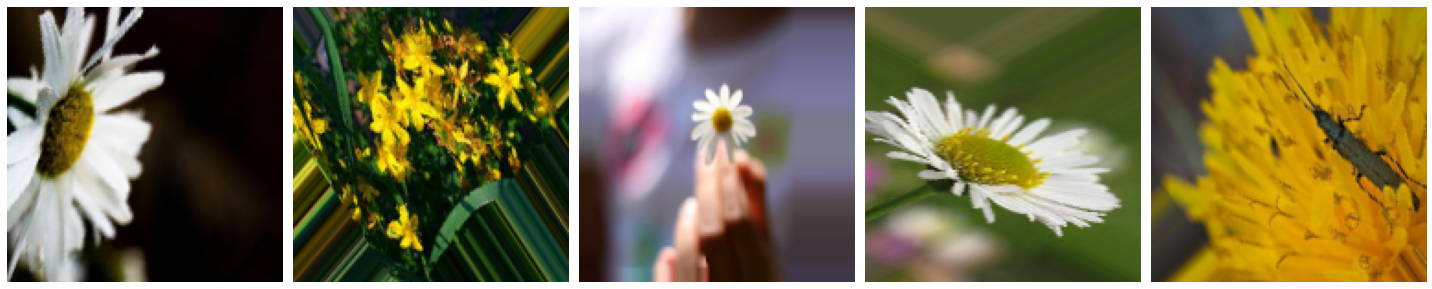

In [5]:
plotImages(sample_training_images[:5])

# callback 함수 만들기

### 실시간 그래프

In [6]:
from IPython.display import clear_output

class PlotLosses(Callback):

    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []

        self.accuracy = []
        self.val_accuracy = []

        self.fig = plt.figure()

        self.logs = []


    def on_epoch_end(self, epoch, logs={}):

        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))

        self.accuracy.append(logs.get('acc'))
        self.val_accuracy.append(logs.get('val_acc'))

        self.i += 1

        clear_output(wait=True)

        print("<실시간 그래프>")
        print("---------------------------------------------------------------")
        print()

        plt.plot(self.x, self.accuracy, label="accuracy")
        plt.plot(self.x, self.val_accuracy, label="val_accuracy")
        plt.title('model accuracy')
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        plt.legend(['accuracy', 'val_accuracy'], loc='upper left')
        plt.show();
        print("accuracy = ", self.accuracy[-1], ", val_accuracy = ", self.val_accuracy[-1])
        
        print()
        print("---------------------------------------------------------------")
        print()
        
        plt.plot(self.x, self.losses, label="loss")
        plt.plot(self.x, self.val_losses, label="val_loss")
        plt.title('model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper right')
        plt.show();
        print("loss = ", self.losses[-1], ", val_loss = ", self.val_losses[-1])


In [7]:
plot_losses = PlotLosses()

### Early Stopping

In [8]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss',  # 모니터링 대상
                               mode='auto',         # 학습 방향을 자동으로 탐지
                               patience=50)         # 중지까지의 여유분

# Vanilla CNN 모델 만들기

### 모델 구축

In [9]:
model = keras.Sequential()

model.add(Conv2D(16, (3, 3), padding='same', activation='relu', input_shape = (150,150,3)))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["acc"])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 150, 150, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 75, 75, 16)        0         
_________________________________________________________________
dropout (Dropout)            (None, 75, 75, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 75, 75, 32)        4640      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 75, 75, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 37, 37, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 37, 37, 64)        0

### 훈련 시작

<실시간 그래프>
---------------------------------------------------------------



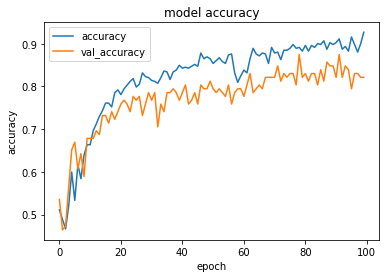

accuracy =  0.9269911646842957 , val_accuracy =  0.8214285969734192

---------------------------------------------------------------



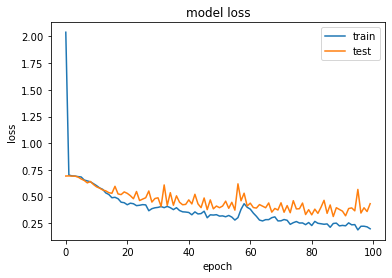

loss =  0.1977584809064865 , val_loss =  0.4330020844936371


In [10]:
history = model.fit(train_data,
                    batch_size = 64,
                    epochs = 100,
                    validation_data = val_data,
                    verbose = 1,
                    callbacks=[early_stopping, plot_losses])

### 최종 그래프

In [11]:
print(history.history.keys())

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])


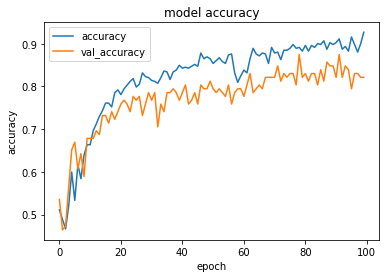

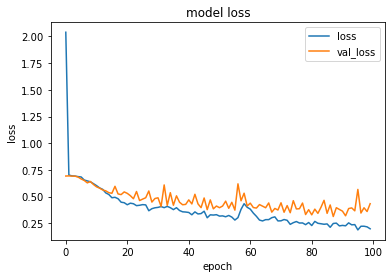

In [12]:
# summarize history for accuracy
plt.plot(history.history[list(history.history.keys())[1]])
plt.plot(history.history[list(history.history.keys())[3]])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['accuracy', 'val_accuracy'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history[list(history.history.keys())[0]])
plt.plot(history.history[list(history.history.keys())[2]])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['loss', 'val_loss'], loc='upper right')
plt.show()

# VGG16 cnn 모델 만들기

### 모델 구축

In [9]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras import models

In [10]:
conv_layers = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
conv_layers.trainable = False

model = models.Sequential()

model.add(conv_layers)
model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer="RMSprop", metrics=['acc'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
dense (Dense)                (None, 1024)              8389632   
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 1025      
Total params: 23,105,345
Trainable params: 8,390,657
Non-trainable params: 14,714,688
_________________________________________________________________


### 훈련 시작

<실시간 그래프>
---------------------------------------------------------------



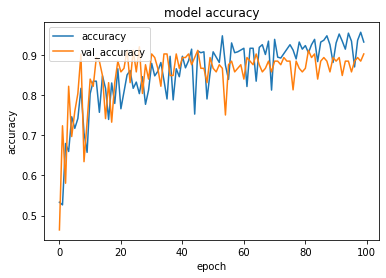

accuracy =  0.9314159154891968 , val_accuracy =  0.9017857313156128

---------------------------------------------------------------



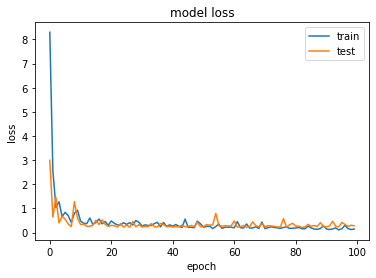

loss =  0.15062761306762695 , val_loss =  0.28184279799461365


In [11]:
history = model.fit(train_data,
                    batch_size = 64,
                    epochs = 100,
                    validation_data = val_data,
                    verbose = 1,
                    callbacks=[early_stopping, plot_losses])

### 최종 그래프

In [12]:
print(history.history.keys())

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])


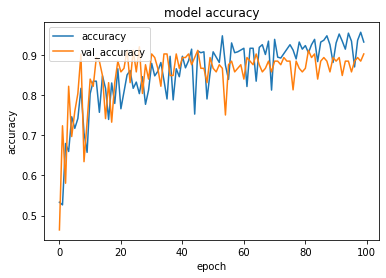

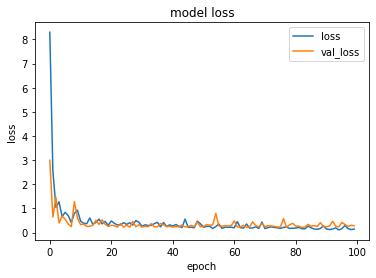

In [13]:
# summarize history for accuracy
plt.plot(history.history[list(history.history.keys())[1]])
plt.plot(history.history[list(history.history.keys())[3]])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['accuracy', 'val_accuracy'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history[list(history.history.keys())[0]])
plt.plot(history.history[list(history.history.keys())[2]])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['loss', 'val_loss'], loc='upper right')
plt.show()